# FIT1043 A2 Assignment - Derek Goh Kai Shen (33521247)

## Part A: Classification

### A1. Supervised Learning
#### 1. Definition of supervised machine learning, the notion of labelled data, and train and test datasets.
- Supervised machine learning is a subset of machine learning where the model is trained upon a labelled dataset to yield a desired output that we can predict. Some of the common algorithms used to train models are neural networks, naive bayes, linear regression, logistic regression, support vector machines(SVM) and more. 

- All the data used in training the model is labelled, as in referring to data that has been classified with the correct output. 

- The training dataset is a set of data that is correctly labelled and includes the input and the respective correct output, which allows the model to learn the relationship between the input and output. The model is then tested on a separate dataset, known as the test dataset, to evaluate its loss function and accuracy index. The model is then tweaked to minimise the loss function and improve the accuracy index.


- Setting up the environment and importing all the necessary libraries.

In [113]:
import tensorflow as tf
keras = tf.keras
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout, Input, BatchNormalization, Activation
from keras.callbacks import EarlyStopping


import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.svm import SVC

import seaborn as sns
import matplotlib.pyplot as plt
import pickle as pkl
import numpy as np

#### 2. Reading `FIT1043-MusicGenre-Dataset.csv` file and separating the features and labels.

#### 3. Splitting the datasets into training and testing datasets using `sklearn.model_selection.train_test_split` functions.

In [114]:
# Loading dataset 
data = pd.read_csv('FIT1043-MusicGenre-Dataset.csv')
data = data.dropna()
demo = data.copy()

demo['duration'] = demo['duration_ms'].apply(lambda x: round(x/1000))
demo['popularity_valence'] = demo['popularity'] * demo['valence']
demo['danceability_energy'] = demo['danceability'] * demo['energy']
demo['acousticness_instrumentalness'] = demo['acousticness'] * demo['instrumentalness']
demo['loudness_energy'] = demo['loudness'] * demo['energy']
demo['speechiness_liveness'] = demo['speechiness'] * demo['liveness']
demo['tempo_energy'] = demo['tempo'] * demo['energy']

# Splitting data into features and labels
demo_features = demo.drop(columns=['music_genre', 'artist_name', 'track_name', 'instance_id', 'duration_ms'])
demo_labels = demo['music_genre']

# Splitting data into training and testing sets
# 80% training, 20% testing, random seed = 42
# To be used for SVM only, since CountVectorizer on SVM takes up too much memory than Colab allowed.
X_train, X_test, y_train, y_test = train_test_split(demo_features, demo_labels, test_size=0.2, random_state=42)

### A2. Classification (Training)
#### 1. Differences between binary and multi-class classification.

- Binary classification is a type of classification where the model is trained to predict between two classes, such as true or false, spam or no, 0 or 1, and so on. The output is a boolean, which is either True or False.

- Multi-class classification is a type of classification where the model is trained to predict between multiple classes, such as classifying between genre of music, colour schemes, dog breeds, and so on. The output is a class label, which is one of the classes that the model is trained to predict.

#### 2. Normalising/Scaling Data for Preparation for Classification

- Normalsing or Scaling of data is important as it allows the model gradient descent to converge faster, as all the features are on the same scale. This is important as we want to scale the data when we are using algorithms using distance between data points, such as Support Vector Machines (SVM) and K-Nearest Neighbours (KNN). For example, if we have a dataset with features that have totally different scales, such as age and income, the model will be biased towards the feature with larger scale, which will be the income in this case.

- There are many ways to scale the data, such as Min-Max Scaling, Standard Scaling, Robust Scaling, and Normalisation. Min-Max Scaling scales the data to a range between 0 and 1, Standard Scaling scales the data to have a mean of 0 and a standard deviation of 1, Robust Scaling scales the data to the interquartile range, and Normalisation scales the data to have a magnitude of 1. The best scaling method for predicting the genre of the music is Standard Scaling, as it scales the data to have a mean of 0 and a standard deviation of 1, which is important for algorithms that use distance between data points.

In [115]:
# Feature engineering
df = data.copy()
df = df.drop(columns = ['instance_id'])
df['duration'] = df['duration_ms'].apply(lambda x: round(x/1000))
df['popularity_valence'] = df['popularity'] * df['valence']
df['danceability_energy'] = df['danceability'] * df['energy']
df['acousticness_instrumentalness'] = df['acousticness'] * df['instrumentalness']
df['loudness_energy'] = df['loudness'] * df['energy']
df['speechiness_liveness'] = df['speechiness'] * df['liveness']
df['tempo_energy'] = df['tempo'] * df['energy']
df['name_combined'] = df['artist_name'] + " " + df['track_name']


# Vectorizing the text data
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(df['name_combined'])

# Seperating features and the label
features = df.drop(columns=['music_genre', 'artist_name', 'track_name', 'name_combined', 'duration_ms'])
label = df['music_genre']

# Convert the sparse matrix to a DataFrame
df_bow = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names_out())

# Normalize
sclr = StandardScaler()
features = pd.DataFrame(sclr.fit_transform(features), columns=features.columns)

# Reset the index of the original DataFrame
features.reset_index(drop=True, inplace=True)

# Concatenate the original DataFrame with the bag of words DataFrame
features = pd.concat([features, df_bow], axis=1)

# Splitting the data into training and testing sets
features_train, features_test, label_train, label_test = train_test_split(features, label, test_size=0.2, random_state=42)

#### 3. Using Support Vector Machines (SVM) for Classification

- SVM is a supervised learning algorithm used in machine learning to solve classification problems. It's very good in solving binary classification problems, but can also be used for multi-class classification problems. The algorithm works by seperating the classes with a hyperplane that has the maximum distance between the nearest data points of the classes, which can be referred to as the margin. The data points that are closest to that hyperplane are called support vectors. The hyperplane can be linear or non-linear, depending on the kernel used. The most common kernel used is the Radial Basis Function (RBF) kernel, or the Gaussian kernel. RBF kernel, which is a non-linear kernel, is used when the data is not linearly separable, and the linear kernel is used when the data is linearly separable.

- Since SVM are fundamentally binary classifiers, to allow them to support multi-class classifications, we can employ either One-Vs-Rest (OvR) or One-Vs-One(OvO) strategies. OvR trains a binary classifier for each class, which is then used to predict the class with the highest confidence score. OvO trains a binary classifier for each pair of classes, which is then used to predict the class with the most votes. OvR is more efficient than OvO, as it requires less training time, but OvO is more accurate than OvR, as it requires more training time. Thus, we have to balance between efficiency and accuracy when choosing between OvR and OvO.

In [116]:
# Building SVM model to classify the music genre.
classifier = SVC(kernel= 'rbf', random_state=42)
classifier.fit(X_train, y_train)

# Save the model
pkl.dump(classifier, open('svm_model.pkl', 'wb'))

#### 4. Using Neural Networks for Classification
- Neural networks are a type of machine learning algorithm that is inspired by how the brain functions. They are the backbones of deep-learning, which is a subset of machine learning that uses multiple layers of neural networks to learn the features of the datasets. By using multiple layers of neural networks, the model can learn the features of the datasets, just like how a human brain would learn something new. The model is trained by tweaking the weights and biases of the neurons in the neural networks to minimise the loss function and improve the accuracy index.

- In this case, we will be using Keras, which is a high-level neural networks API, built on Tensorflow, which is developed by Google. Keras works by stacking layers of neural networks, which are then trained using the backpropagation algorithm. The backpropagation algorithm works by tweaking the weights and biases of the neurons in the neural networks to minimise the loss function and improve the accuracy index.

In [117]:
# Building the model
model = Sequential()

model.add(Input(shape=(features_train.shape[1],)))
model.add(Dense(100))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(Dense(100))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(Dense(150))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.2))

model.add(Dense(150))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.2))

model.add(Dense(100))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.2))

model.add(Dense(50))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(Dense(20))
model.add(BatchNormalization())
model.add(Activation('relu'))

# Output layer
model.add(Dense(10, activation = 'softmax'))

# Compiling the model
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
# Define the early stopping criteria
stop_early = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)

# Training the model
model.fit(features_train, label_train, epochs=100, batch_size=64, validation_data=(features_test, label_test), callbacks=[stop_early])

# Evaluate the model
loss, accuracy = model.evaluate(features_test, label_test)
print(f'Accuracy: {accuracy*100}%')

model.save("nn_model.keras")

Epoch 1/100
325/325 ━━━━━━━━━━━━━━━━━━━━ 29s 74ms/step - accuracy: 0.3458 - loss: 1.8403 - val_accuracy: 0.5589 - val_loss: 1.2708
Epoch 2/100
325/325 ━━━━━━━━━━━━━━━━━━━━ 19s 57ms/step - accuracy: 0.6819 - loss: 0.8805 - val_accuracy: 0.6868 - val_loss: 0.8737
Epoch 3/100
325/325 ━━━━━━━━━━━━━━━━━━━━ 18s 56ms/step - accuracy: 0.7846 - loss: 0.5862 - val_accuracy: 0.6988 - val_loss: 0.8227
Epoch 4/100
325/325 ━━━━━━━━━━━━━━━━━━━━ 18s 57ms/step - accuracy: 0.8395 - loss: 0.4445 - val_accuracy: 0.6980 - val_loss: 0.8578
Epoch 5/100
325/325 ━━━━━━━━━━━━━━━━━━━━ 18s 56ms/step - accuracy: 0.8701 - loss: 0.3630 - val_accuracy: 0.7086 - val_loss: 0.8914
Epoch 6/100
325/325 ━━━━━━━━━━━━━━━━━━━━ 18s 56ms/step - accuracy: 0.8953 - loss: 0.2984 - val_accuracy: 0.7074 - val_loss: 0.9140
Epoch 7/100
325/325 ━━━━━━━━━━━━━━━━━━━━ 18s 56ms/step - accuracy: 0.9090 - loss: 0.2673 - val_accuracy: 0.7076 - val_loss: 0.9347
Epoch 8/100
325/325 ━━━━━━━━━━━━━━━━━━━━ 18s 57ms/step - accuracy: 0.9158 - loss: 0

- Checking stability of model against different splits of the dataset. Important to check, as the model might be overfitting the particular training datasets, and not generalising well to the test datasets.

In [118]:
# Splitting the data into training and testing sets
# 80% training, 20% testing, random seed = 0
features_train, features_test, label_train, label_test = train_test_split(features, label, test_size=0.2, random_state=0)

# Loading the model
model = load_model('nn_model.keras')

# Continue training
model.fit(features_train, label_train, epochs=100, batch_size=64, validation_data=(features_test, label_test), callbacks=[stop_early])

# Evaluate the model
loss, accuracy = model.evaluate(features_test, label_test)
print(f'Accuracy: {accuracy*100}%')

# Save the model again
model.save("final_model.keras")

Epoch 1/100
325/325 ━━━━━━━━━━━━━━━━━━━━ 30s 72ms/step - accuracy: 0.8874 - loss: 0.3573 - val_accuracy: 0.9004 - val_loss: 0.2943
Epoch 2/100
325/325 ━━━━━━━━━━━━━━━━━━━━ 19s 57ms/step - accuracy: 0.9202 - loss: 0.2233 - val_accuracy: 0.8893 - val_loss: 0.3178
Epoch 3/100
325/325 ━━━━━━━━━━━━━━━━━━━━ 18s 57ms/step - accuracy: 0.9350 - loss: 0.1795 - val_accuracy: 0.8815 - val_loss: 0.3534
Epoch 4/100
325/325 ━━━━━━━━━━━━━━━━━━━━ 18s 56ms/step - accuracy: 0.9403 - loss: 0.1554 - val_accuracy: 0.8698 - val_loss: 0.4117
Epoch 5/100
325/325 ━━━━━━━━━━━━━━━━━━━━ 18s 57ms/step - accuracy: 0.9441 - loss: 0.1490 - val_accuracy: 0.8658 - val_loss: 0.4344
Epoch 6/100
325/325 ━━━━━━━━━━━━━━━━━━━━ 19s 57ms/step - accuracy: 0.9475 - loss: 0.1336 - val_accuracy: 0.8646 - val_loss: 0.4731
Epoch 7/100
325/325 ━━━━━━━━━━━━━━━━━━━━ 19s 58ms/step - accuracy: 0.9509 - loss: 0.1245 - val_accuracy: 0.8634 - val_loss: 0.4870
Epoch 8/100
325/325 ━━━━━━━━━━━━━━━━━━━━ 20s 61ms/step - accuracy: 0.9510 - loss: 0

### A3. Classification (Prediction)
#### 1. Using the trained models from SVM and Neural Networks to predict the genre (label) of the music.

In [119]:
# SVM model
# Predicting the test set results
svm_label_pred = classifier.predict(X_test)

# Making the confusion matrix
svm_cm = confusion_matrix(y_test, svm_label_pred)

# Neural Networks model
# Predicting the test set results
nn_label_pred = np.argmax(model.predict(features_test), axis=-1)

# Making the confusion matrix
nn_cm = confusion_matrix(label_test, nn_label_pred)

163/163 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step


#### 2. Evaluating the performance of the models using confusion matrix and accuracy score.

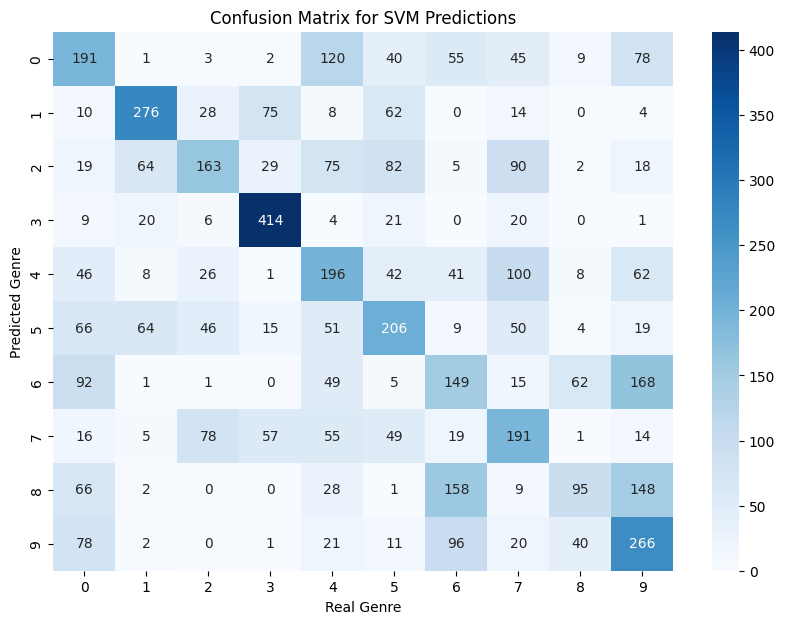

In [120]:
# Plotting the SVM confusion matrix into heatmap
plt.figure(figsize=(10, 7))
sns.heatmap(svm_cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Real Genre')
plt.ylabel('Predicted Genre')
plt.title('Confusion Matrix for SVM Predictions')
plt.show()

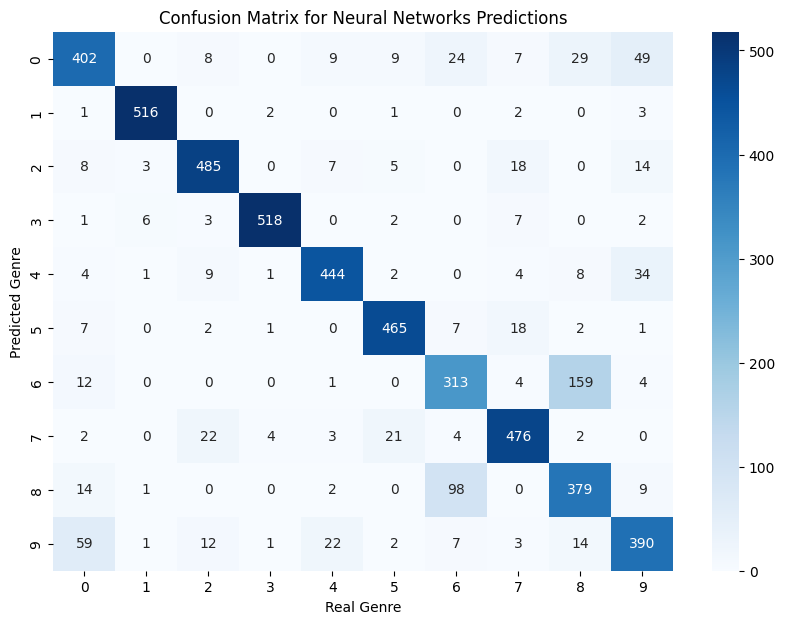

In [121]:
# Plotting the Neural Networks confusion matrix into heatmap
plt.figure(figsize=(10, 7))
sns.heatmap(nn_cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Real Genre')
plt.ylabel('Predicted Genre')
plt.title('Confusion Matrix for Neural Networks Predictions')
plt.show()

#### 3. Comparing the performance of SVM and Neural Networks Models.
- As we can see from the confusion matrix and accuracy score, the SVM has an accuracy score of `41.35%`, while the Neural Networks has an accuracy score of `85.05%`. The SVM's confusion matrix shows that it is more scattered than the Neural Networks, which shows that the Neural Networks is more accurate than the SVM. This is because the Neural Networks is able to learn the features of the datasets better than the SVM, as it uses multiple layers of neural networks to learn the features of the datasets. The SVM is only able to learn the features of the datasets using a hyperplane, which is not as accurate as the Neural Networks.

In [122]:
accuracy = accuracy_score(y_test, svm_label_pred)
print(f'Accuracy for SVM: {accuracy}')

accuracy = accuracy_score(label_test, nn_label_pred)
print(f'Accuracy for Neural Networks: {accuracy}')

Accuracy for SVM: 0.41352080123266566
Accuracy for Neural Networks: 0.8451463790446841


### A4 Independent Evaluation
#### 1. Using the best trained model to predict the genre of the music in the `FIT1043-MusicGenre-Submission.csv` file.

In [123]:
# Loading Submission Data
submission_data = pd.read_csv('FIT1043-MusicGenre-Submission.csv')
submission_data = submission_data.dropna()

# Feature engineering
sub_df = submission_data.copy()
sub_df = sub_df.drop(columns = ['instance_id'])
sub_df['duration'] = sub_df['duration_ms'].apply(lambda x: round(x/1000))
sub_df['popularity_valence'] = sub_df['popularity'] * sub_df['valence']
sub_df['danceability_energy'] = sub_df['danceability'] * sub_df['energy']
sub_df['acousticness_instrumentalness'] = sub_df['acousticness'] * sub_df['instrumentalness']
sub_df['loudness_energy'] = sub_df['loudness'] * sub_df['energy']
sub_df['speechiness_liveness'] = sub_df['speechiness'] * sub_df['liveness']
sub_df['tempo_energy'] = sub_df['tempo'] * sub_df['energy']
sub_df['name_combined'] = sub_df['artist_name'] + " " + sub_df['track_name']


# Vectorizing the text data
X = vectorizer.transform(sub_df['name_combined'])

# Finding features
features = sub_df.drop(columns=['artist_name', 'track_name', 'name_combined', 'duration_ms'])

# Convert the sparse matrix to a DataFrame
sub_df_bow = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names_out())

# Normalize
sclr = StandardScaler()
features = pd.DataFrame(sclr.fit_transform(features), columns=features.columns)

# Reset the index of the original DataFrame
features.reset_index(drop=True, inplace=True)

# Concatenate the original DataFrame with the bag of words DataFrame
features = pd.concat([features, sub_df_bow], axis=1)

# Loading the keras model
model = load_model('final_model.keras')

# Step 4: Use the model to predict the music genre
predictions = model.predict(features)
class_labels = np.argmax(predictions, axis=1)

# Step 5: Add the predictions to the dataframe
sub_df['music_genre'] = class_labels

sub_df['instance_id'] = submission_data['instance_id']
final_df = sub_df[['instance_id', 'music_genre']]

# Step 6: Write the dataframe to a new CSV file
final_df.to_csv('33521247-Derek Goh Kai Shen-v1.csv', index=False)

203/203 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step


### A5. Kaggle Competition
- Submitted `33521247-Derek Goh Kai Shen-v1.csv` to the Kaggle competition, which has an accuracy score of `70.431%`.

## Part B: Selection of Dataset, Clustering and Video Preparation

### B1. Selection of Dataset with missing data, Clustering

#### 1. Reading the `CC_GENERAL.csv` file and checking for missing data.

- The dataset contains missing data, which is important to handle before we can use it for clustering. We can handle missing data by either removing the rows with missing data, or imputing the missing data with the mean, median, or mode of the column or even 0. In this case, we will be ignoring the columns with many NaN values.

- Link to dataset: `https://www.kaggle.com/datasets/arjunbhasin2013/ccdata/data`

In [124]:
# Load the data
creds = pd.read_csv('CC_GENERAL.csv')

# Find out the number of missing values in each column
missing_values = creds.isnull().sum()
print(f'Missing values:\n{missing_values}')
creds = creds.dropna()



Missing values:
CUST_ID                               0
BALANCE                               0
BALANCE_FREQUENCY                     0
PURCHASES                             0
ONEOFF_PURCHASES                      0
INSTALLMENTS_PURCHASES                0
CASH_ADVANCE                          0
PURCHASES_FREQUENCY                   0
ONEOFF_PURCHASES_FREQUENCY            0
PURCHASES_INSTALLMENTS_FREQUENCY      0
CASH_ADVANCE_FREQUENCY                0
CASH_ADVANCE_TRX                      0
PURCHASES_TRX                         0
CREDIT_LIMIT                          1
PAYMENTS                              0
MINIMUM_PAYMENTS                    313
PRC_FULL_PAYMENT                      0
TENURE                                0
dtype: int64


#### 2. Performing k-means clustering on the dataset.
- Before performing k-means clustering, we can use Feature Engineering to select the best features for clustering.

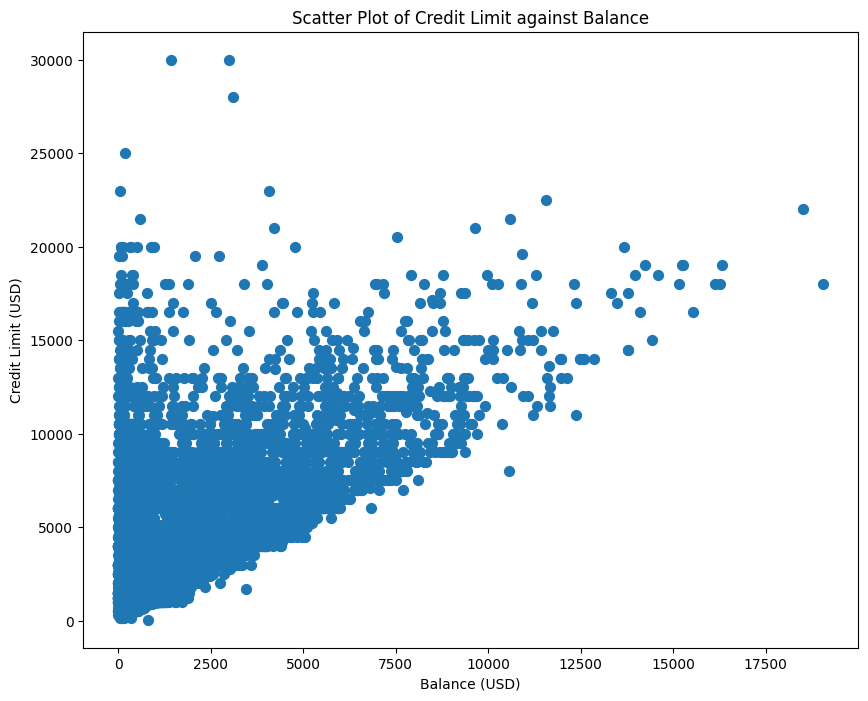

KMeans(n_clusters=4, n_init=10, random_state=42)

In [125]:
# Extract the 'BALANCE' and 'PURCHASES_FREQUENCY' columns
creds = creds[['BALANCE', 'CREDIT_LIMIT']]

# Plotting the scatter plot
plt.figure(figsize=(10, 8))
plt.scatter(x=creds['BALANCE'], y=creds['CREDIT_LIMIT'], s=50)
plt.xlabel('Balance (USD)')
plt.ylabel('Credit Limit (USD)')
plt.title('Scatter Plot of Credit Limit against Balance')

plt.show()
kmeans = KMeans(n_clusters=4, random_state=42, n_init=10)
kmeans.fit(creds)

#### 3. Visualising the clusters using a scatter plot.
- We visualised the clusters in the scatter plot, which are formed by the k-means clustering algorithm. The clusters are formed by the centroids of the clusters, which are the mean of the data points in the clusters. The data points are then assigned to the clusters based on the distance between the data points and the centroids of the clusters.

- Based on the 4 clusters visualised below, we can relate them to the 4 Socio-economic Classes in the dataset, which are `Lower`, `Middle`, `Working`, and `Upper`. 

- The `Lower` class is the `Purple` cluster with the lowest credit limit and the lowest balance. It reflects in real world, where people who are in the `Lower` class earn lesser, thus have lower credit scores and balances.

- The `Middle` class is the `Light Green` cluster with moderate credit limit and moderate balance amount. In real world, people in the `Middle` class tend to earn higher than those who were in `Lower` class, thus have higher credit scores and balances than `Lower` class.

- The `Working` class is the `Dark Blue` cluster with higher credit limit and similar balance amount. In real world, people in `Working` class have consistent income from their work, but at the same time, have to bear higher expenses such as housing, car loans, transportation costs, parking, food, and so on. Thus banks tend to give them higher credit limits, although their balances are similar to `Middle` class.

- The `Upper` class is the `Yellow` cluster with high credit limit similar to `Working` class but have the highest balance amount. In real world, people in `Upper` class have high income, high savings, and high investments, thus have high credit limits and high balances. Although they have high income, they don't need as much credit as `Working` class, as they are able to pay with cash fully.


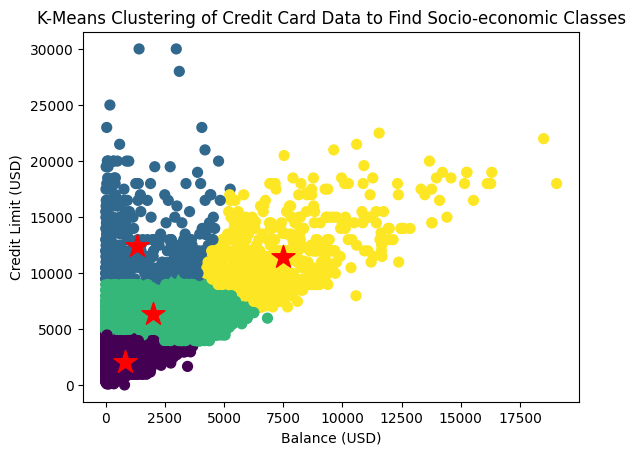

In [126]:
plt.scatter(creds['BALANCE'], creds['CREDIT_LIMIT'], c=kmeans.labels_, s=50)
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s=300, c='red', marker='*')

plt.xlabel('Balance (USD)')
plt.ylabel('Credit Limit (USD)')
plt.title('K-Means Clustering of Credit Card Data to Find Socio-economic Classes')
plt.show()